[**AN INTRODUCTION TO INFERENCE IN PYRO**](http://pyro.ai/examples/intro_part_ii)

# Inference

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [54]:
import pyro
from pyro import infer, optim, distributions as dist, sample, param

### ex1. simple model

* consider the model:
    * $weight  |  guess \sim Normal(guess, 1)$ 
    * $measurement | guess, weight \sim Normal(weight, 0.75)$

* note that 
    * it encodes belief on weight and measurement
    * it is a generative model for the joint probability of $weight$ and $measurement$

In [14]:
def scale(guess):
    # Get weight from guess
    weight = sample('weight', dist.Normal(guess, 1.))
    
    # Get measurement from weight
    measurement = sample('measurement', dist.Normal(weight, .75))
    return measurement.item()

In [5]:
[scale(i*.2) for i in range(10)]

[-0.500455379486084,
 -0.21372061967849731,
 1.157045602798462,
 0.4046907424926758,
 -0.6650682091712952,
 0.3975140154361725,
 -0.2733139991760254,
 1.3474061489105225,
 2.1665823459625244,
 3.0276918411254883]

## Conditioning

* the real utility of ppl's come from:
    * the ability of generative models to condition on observed data
    * infer the latent factors that might have produced the data
* in `pyro`, this is carried by separating the **expression of conditioning** from **its evaluation** via inference (?):
    * write a model once
    * then condition it on data - by *constraining* a model's internal `sample` statements to be equal to a given set of observations


### ex1.2 conditioning the simple model

* suppose we want to sample from distribution of `weight`, given `guess == 8.5`
* but now we've observed `measurement == 9.5`
* we then want to infer:
$$ (weight | guess, measurement) \sim ? $$ 

* we can condition with `pyro.condition`

In [8]:
conditioned_scale = pyro.condition(scale, data={'measurement': torch.tensor(9.5)})

In [10]:
type(conditioned_scale)

pyro.poutine.messenger._bound_partial

* or create directly a function with observed statements in `pyro.sample`

In [13]:
def scale_observed(guess):
    # Get weight from guess
    weight = sample('weight', dist.Normal(guess, 1.))
    
    # Get measurement from weight, with observed data
    measurement = sample('measurement', dist.Normal(weight, .75), obs=torch.tensor(9.5))
    return measurement.item()

In [21]:
scale_observed(torch.tensor(8.))

C:\Users\frazao\Miniconda3\envs\ppl\lib\site-packages\pyro\primitives.py:138: RuntimeWarning: trying to observe a value outside of inference at measurement
  warnings.warn(


9.5

**NOTE**:
* these conditioned functions don't work for sampling anymore - just for optimizing an inference guide!

* given the posterior on this is tractable, we can get directly the perfect guide (in general, we want to optimize for the parameters of such a guide)

In [22]:
def perfect_guide(guess):
    loc = (0.75**2 * guess + 9.5) / (1 + 0.75**2)  # 9.14
    scale = np.sqrt(0.75**2 / (1 + 0.75**2))  # 0.6
    return pyro.sample("weight", dist.Normal(loc, scale))

In [53]:
perfect_guide(8.)

tensor(8.9210)

## Param store

### ex2. parameters

In [55]:
def scale_parameterized_guide(guess):
    # Define parameters for posterior
    loc = param('loc', torch.tensor(guess))
    scale_ = param('scale_', torch.tensor(1.), constraint=dist.constraints.positive)
    
    # Get weight from guess
    weight = sample('weight', dist.Normal(loc, scale_))

In [57]:
pyro.get_param_store().keys()

dict_keys([])

## SVI

In [59]:
# Data
guess = 8.5

# Clear parameter store
pyro.clear_param_store()

# Set svi
svi = infer.SVI(
    model=conditioned_scale,
    guide=scale_parameterized_guide,
    optim=optim.Adam({'lr': 0.003}),
    loss=infer.Trace_ELBO()
)

# Train
losses, loc_list, scale_list = [], [], []

for t in range(2500):
    losses.append(svi.step(guess))
    loc_list.append(param('loc').item())
    scale_list.append(param('scale_').item())
    

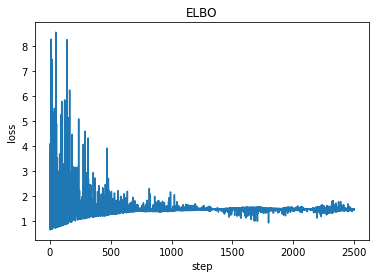

In [60]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

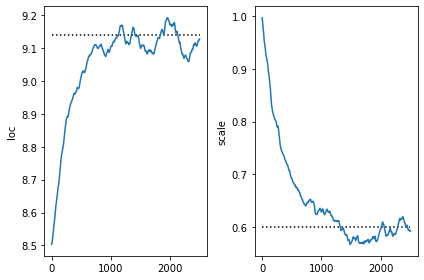

In [62]:
plt.subplot(1,2,1)
plt.plot([0,2500],[9.14,9.14], 'k:')
plt.plot(loc_list)
plt.ylabel('loc')

plt.subplot(1,2,2)
plt.ylabel('scale')
plt.plot([0,2500],[0.6,0.6], 'k:')
plt.plot(scale_list)
plt.tight_layout()